In [1]:
!pip3 install -U ucimlrepo
!pip install -U scikit-learn

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo, list_available_datasets

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
auto_mpg = fetch_ucirepo(id=9)

X = auto_mpg.data.features
y = auto_mpg.data.targets

In [125]:
df_features = pd.DataFrame(X, columns=auto_mpg.data.feature_names)

# initial power factor per cubic inch
pfci = 3.78

# filling missing values with apprx values using (displacement/cylinders) * pfci
df_features['horsepower'] = df_features['horsepower'].fillna((df_features['displacement'] / df_features['cylinders']) * pfci)

In [121]:
x_train, x_temp, y_train, y_temp = train_test_split(df_features, y, test_size = 0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [122]:
model = LinearRegression()
model.fit(x_train_scaled, y_train)

y_val_predict = model.predict(x_val_scaled)
y_test_predict = model.predict(x_test_scaled)

<!-- Implement my own example data -->

In [169]:
x_my_data = np.array([[396.0, 4, 101, 2866, 12.3, 99, 2]])
x_my_data_scaled = scaler.transform(x_my_data)

y_my_data = model.predict(x_my_data_scaled)

C:\Users\O_O\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<!-- Predicted data score using data without regularization / using iniatial value of pfci -->

In [123]:
print(model.score(x_train_scaled, y_train))
print(model.score(x_test_scaled, y_test))

print(f'MSE: {mean_squared_error(y_val, y_val_predict)}')
print(f'r2 score: {r2_score(y_val, y_val_predict)}')

print(f'MSE for test: {mean_squared_error(y_test, y_test_predict)}')
print(f'r2 score for test: {r2_score(y_test, y_test_predict)}')

0.8111993341108301
0.8525868064633747
MSE: 8.760017335988982
r2 score: 0.8214645718070362
MSE for test: 9.685036987810044
r2 score for test: 0.8525868064633747


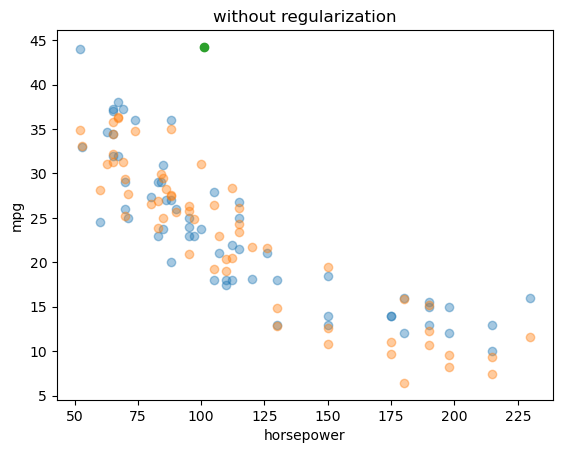

In [170]:
plt.scatter(x_test['horsepower'], y_test, alpha=0.4)
plt.scatter(x_test['horsepower'], y_test_predict, alpha=0.4)
plt.scatter(x_my_data[0][2], y_my_data, alpha=1)

plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('without regularization')
plt.show()

In [128]:
print(x_test.head())

     displacement  cylinders  horsepower  weight  acceleration  model_year  \
82          120.0          4        97.0    2506          14.5          72   
180         121.0          4       115.0    2671          13.5          75   
93          318.0          8       150.0    4237          14.5          73   
39          400.0          8       175.0    4464          11.5          71   
114          98.0          4        90.0    2265          15.5          73   

     origin  
82        3  
180       2  
93        1  
39        1  
114       2  
